In [16]:
import pandas as pd
import numpy as np
import datetime

#Libraries for data visualization
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Libraries for text pre-processing
import re
import nltk
# Stopwords needs to be downloaded before use
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
# WordNetLemmatizer needs to be downloaded before use
from nltk.stem.wordnet import WordNetLemmatizer
#To track function execution
from tqdm import tqdm
from bs4 import BeautifulSoup

#Libraries for text preparation and visualization
from sklearn.feature_extraction.text import TfidfVectorizer as T
from sklearn.feature_extraction.text import CountVectorizer as c
from sklearn.feature_extraction.text import TfidfTransformer as Tf
from sklearn.decomposition import LatentDirichletAllocation 
from scipy.sparse import coo_matrix

#Libraries for Sentimental analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Loading spark libraries
import pyspark
import string
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *

#For cleaning Text
from pyspark.sql.functions import col, lower, regexp_replace, split, size, length

# Spark Machine Learning Libraries
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover  
from pyspark.ml.feature import VectorAssembler, IDF, StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kaushik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kaushik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv("/home/kaushik/to_share/Eluvio_DS_Challenge.csv")
#making a copy of dataframe for later phase
df2 = df
# Checking for Null values.
df.isnull().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

In [4]:
# Checking for unique values in each column
unique_plot = {}
for i in df.columns:
  unique_plot[i] = df[i].nunique()

unique_df = pd.DataFrame(data = unique_plot, index = [0])
unique_df

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,508329,3223,5782,1,500720,2,85838,1


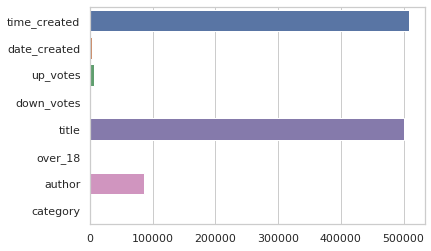

In [5]:
#Plotting the graph for visualizing the above findings.
sns.set(style="whitegrid")
ax = sns.barplot(data=unique_df,orient = 'h')

In [6]:
# Checking for duplicate values
df[df.duplicated()]

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
4179,1208626819,2008-04-19,0,0,Mortal Kombat vs. DC Universe xbox 360 game pr...,False,Aerik,worldnews
5593,1210005800,2008-05-05,0,0,Independent News Reports Surge In Sadr City ...,False,MikaelMN,worldnews
7567,1211901242,2008-05-27,0,0,"Trouble comes in threes, with quakes it is man...",False,BookWormPride,worldnews
11684,1216100913,2008-07-15,0,0,redditors are often keen to talk about conspir...,False,cthulhufhtagn,worldnews
11876,1216254290,2008-07-17,0,0,Saudi king opens inter-faith summit,False,cup,worldnews
56926,1274795505,2010-05-25,0,0,Germany After the EU and the Russian Scenario,False,greenHaired,worldnews


In [7]:
#After dropping the duplicates 
df.drop_duplicates().head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [8]:
# Dropping category and down_votes as they have same values.
df.drop(columns=["down_votes","category"],axis = 1, inplace = True)

# Extracting Year the article was published.
df["year"] = pd.to_datetime(df['date_created']).dt.year

#Number of articles published Each year.
df[["title","year"]].groupby("year").count()

,title
year,
2008,22505
2009,25115
2010,23313
2011,38886
2012,42643
2013,88231
2014,92030
2015,94621
2016,81892


# Text Preprocessing for Data Exploration

In [9]:
#Checking for top 20 most repeated words - Gives insights on data specific stop words.
common_words = pd.Series(' '.join(df["title"]).split()).value_counts()
common_words[:20]

to       204943
in       196008
the      176203
of       170501
a         93169
and       84224
s         78501
for       75960
on        70010
-         40879
as        36251
by        35947
is        35737
with      34999
The       34700
from      31750
at        28978
has       27895
that      27592
after     24864
dtype: int64

In [10]:
# Building our Stop words list to be removed. - Take list of inbuilt stopwords and customizing it by added stopwords specific to this documents (From most common words generated in above step)
stop_words = set(stopwords.words("english")) 

#Adding common words of this document to stop_words
add_words = ["to","in","the","of","a","and","s","-","as","by","for","is","with","The","from","at","has","that","after"]
stop_words = stop_words.union(add_words)

#Below is the function to clean the text and prepare it for next phase. 
from tqdm import tqdm
corpus = []
def clean_content(data):
    cleaned_content = []

    for sent in tqdm(data):
        
        #remove html content
        review_content = BeautifulSoup(sent).get_text()
            
        #remove non-alphabetic characters
        review_content = re.sub("[^a-zA-Z]"," ", review_content)
    
        #tokenize the sentences
        words = word_tokenize(review_content.lower())
    
        #lemmatize each word to its lemma
        lem = WordNetLemmatizer()
        lemma_words = [lem.lemmatize(word) for word in words if not word in stop_words] 
        lemma_words = " ".join(lemma_words)
        cleaned_content.append(lemma_words)
        
        corpus.append(lemma_words)
        
        
    return(cleaned_content)

In [11]:
# Calling the clean_content method to clean the titel column of the dataset
df["cleaned_content"] = clean_content(df["title"])

  0%|          | 1451/509236 [00:01<31:09:59,  4.53it/s]/home/kaushik/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "http://mentalmasturbator.com/2008/03/21/democrats-losing-electoral-advantage/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
  5%|▌         | 26648/509236 [00:10<02:38, 3051.65it/s]/home/kaushik/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "http://www.comcast.net/data/fan/html/popup.html?v=1030143489&pl=Comcast/1030032788.xml&launchpoint=Cover&cid=fancover&attr=default_headline&config=/config/common/fan/default.xml" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beauti

In [12]:
df.head()

,time_created,date_created,up_votes,title,over_18,author,year,cleaned_content
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,2008,score killed pakistan clash
1,1201232075,2008-01-25,2,Japan resumes refuelling mission,False,polar,2008,japan resume refuelling mission
2,1201232523,2008-01-25,3,US presses Egypt on Gaza border,False,polar,2008,u press egypt gaza border
3,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,2008,jump start economy give health care
4,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,2008,council europe bash eu un terror blacklist


# Data Exploration

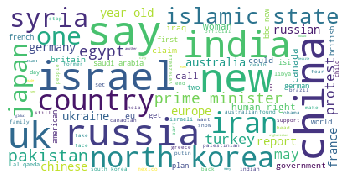

In [13]:
#Visualizing the content after pre-processing for most frequently used words.
wordcloud = WordCloud(
                    background_color = "white",
                    stopwords = stop_words,
                    max_words = 100,
                    max_font_size = 50).generate(str(corpus))

# Displaying the word cloud
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

[Text(0, 0, 'say'),
 Text(0, 0, 'china'),
 Text(0, 0, 'new'),
 Text(0, 0, 'year'),
 Text(0, 0, 'attack'),
 Text(0, 0, 'syria'),
 Text(0, 0, 'russia'),
 Text(0, 0, 'world'),
 Text(0, 0, 'state'),
 Text(0, 0, 'government'),
 Text(0, 0, 'police'),
 Text(0, 0, 'israel'),
 Text(0, 0, 'iran'),
 Text(0, 0, 'president'),
 Text(0, 0, 'killed'),
 Text(0, 0, 'people'),
 Text(0, 0, 'war'),
 Text(0, 0, 'russian'),
 Text(0, 0, 'country'),
 Text(0, 0, 'minister')]

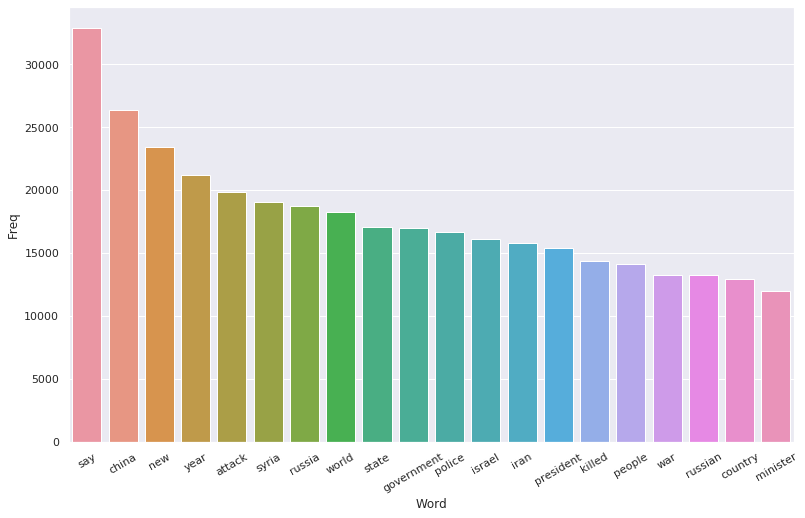

In [19]:
#Visualizing the Most frequently occuring words after cleanup process. 
def get_top_n_words(corpus, n=None):
    vec = c().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [21]:
# Defining a count vectorizer 
cv = c(max_df = 0.95, min_df = 2, stop_words= stop_words)
dtm = cv.fit_transform(df["cleaned_content"])

# Topic Modelling using LDA


    Since the news is categorised into only worldnews, i will further split it into 5 more topics using LDA.

In [ ]:
LDA5 = LatentDirichletAllocation(n_components=5,random_state=42)
LDA5.fit(dtm)

In [ ]:
# Displaying top 15 words of all the topics
for index,topic in enumerate(LDA5.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

In [ ]:
topic_result = LDA5.transform(dtm)
print(topic_result.shape)
df["topic"] = topic_result.argmax(axis=1)

In [ ]:
df.head()

# Sentiment Analysis to define positive or negative sentiment

In [22]:
# Initializing the sentimental Intenity Analyzer
sid = SentimentIntensityAnalyzer()

def sentiment(x):
    dic = sid.polarity_scores(x)
    if dic["compound"] >= 0:
        return 1
    else:
        return 0

In [23]:
#sentiment_df = df.select(sentiment(col("title")).alias("sentiment_score"))
#Appending sentimental scores to the data frame
df2["sentimental_scores"] = df2["title"].apply(lambda x: sentiment(x))

In [24]:
df2.head()

,time_created,date_created,up_votes,title,over_18,author,year,cleaned_content,sentimental_scores
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,2008,score killed pakistan clash,0
1,1201232075,2008-01-25,2,Japan resumes refuelling mission,False,polar,2008,japan resume refuelling mission,1
2,1201232523,2008-01-25,3,US presses Egypt on Gaza border,False,polar,2008,u press egypt gaza border,1
3,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,2008,jump start economy give health care,1
4,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,2008,council europe bash eu un terror blacklist,0


In [26]:
df1 = df2
df1.drop(['time_created', 'date_created','author','year','cleaned_content'], axis = 1, inplace = True)

In [27]:
df1.head()

,up_votes,title,over_18,sentimental_scores
0,3,Scores killed in Pakistan clashes,False,0
1,2,Japan resumes refuelling mission,False,1
2,3,US presses Egypt on Gaza border,False,1
3,1,Jump-start economy: Give health care to all,False,1
4,4,Council of Europe bashes EU&UN terror blacklist,False,0


# Building the Models on Spark using Pyspark

In [28]:
spark = SparkSession.builder.master('local[*]').appName('nlp').getOrCreate() 
#sdf = sqlContext.sql("Select * from spark_input")

# Creating Soark Dataframe from Pandas Dataframe. 
sqlCtx = SQLContext(spark)
sdf1 = sqlCtx.createDataFrame(df1)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f0bd85f6b00>
Traceback (most recent call last):
  File "/home/kaushik/spark-2.4.5-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'CountVectorizer' object has no attribute '_java_obj'


# Given Sentence Predicting Sentiment

In [29]:
sdf1.show(5)
sdf1.printSchema()

+--------+--------------------+-------+------------------+
|up_votes|               title|over_18|sentimental_scores|
+--------+--------------------+-------+------------------+
|       3|Scores killed in ...|  false|                 0|
|       2|Japan resumes ref...|  false|                 1|
|       3|US presses Egypt ...|  false|                 1|
|       1|Jump-start econom...|  false|                 1|
|       4|Council of Europe...|  false|                 0|
+--------+--------------------+-------+------------------+
only showing top 5 rows

root
 |-- up_votes: long (nullable = true)
 |-- title: string (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- sentimental_scores: long (nullable = true)



In [30]:
#sdf.groupBy('sentimental_scores').count().show()
#sdf1 = sdf.filter(sdf.sentimental_scores. isNotNull())
#sdf1.show(5)

In [31]:
# Creating the dataframe with title and sentimental scores.
data = sdf1.select(["title","sentimental_scores"])
data.groupBy('sentimental_scores').count().show()

+------------------+------+
|sentimental_scores| count|
+------------------+------+
|                 0|268872|
|                 1|240364|
+------------------+------+



In [32]:
#Adding Length of each sentence
data = data.withColumn('length',length(data['title']))
data.show(5)

+--------------------+------------------+------+
|               title|sentimental_scores|length|
+--------------------+------------------+------+
|Scores killed in ...|                 0|    33|
|Japan resumes ref...|                 1|    32|
|US presses Egypt ...|                 1|    31|
|Jump-start econom...|                 1|    44|
|Council of Europe...|                 0|    47|
+--------------------+------------------+------+
only showing top 5 rows



In [33]:
#Checking the mean Length of the Positive and Negative sentiments
data.groupBy('sentimental_scores').mean().show()

+------------------+-----------------------+-----------------+
|sentimental_scores|avg(sentimental_scores)|      avg(length)|
+------------------+-----------------------+-----------------+
|                 0|                    0.0|95.76083787080842|
|                 1|                    1.0|82.38237423241416|
+------------------+-----------------------+-----------------+



# Support vector classifier to predict the sentiment of the given title.

In [34]:
svc = LinearSVC()

Building the Pipeline

In [35]:
tokenizer = Tokenizer(inputCol="title", outputCol='token_text')
stopremove = StopWordsRemover(inputCol="token_text", outputCol="stop_tokens")
count_vec = CountVectorizer(inputCol="stop_tokens", outputCol='c_vec')
idf = IDF(inputCol='c_vec', outputCol='tf_idf')
clean_up = VectorAssembler(inputCols=['tf_idf','length'], outputCol='features')

In [36]:
# Creating the pipline for the above process. 
data_prep_pipe = Pipeline(stages=[tokenizer,stopremove,count_vec,idf,clean_up])

In [37]:
# Passing the data through the pipline and preparing it for the ml model
cleaner = data_prep_pipe.fit(data)
cleaner_data = cleaner.transform(data)

Training and Evaluation

In [38]:
#Renaming the sentiment_score column to label as thats the name accepted by the model
clean_data = cleaner_data.select(col('sentimental_scores').alias('label'),col('features'))
clean_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(209724,[15,52,41...|
|    1|(209724,[47,601,4...|
|    1|(209724,[5,55,71,...|
|    1|(209724,[293,488,...|
|    0|(209724,[105,156,...|
+-----+--------------------+
only showing top 5 rows



In [31]:
# Performing the train test split. (Training data = 70%, Testing data = 30%)
(train,test) = clean_data.randomSplit([0.7,0.3])
sentiment_classifier = svc.fit(train)
#sentiment_classifier.save("sentimental_classifier.model")

In [32]:
#sentiment_classifier = LinearSVC.load("spark-2.4.5-bin-hadoop2.7/python/sentimental_classifier.model")
test_results = sentiment_classifier.transform(test)
test_results.show(5)

+-----+--------------------+--------------------+----------+
label| features| rawPrediction|prediction|
+-----+--------------------+--------------------+----------+
 0|(206619,[0,1,2,4,...|[1.19019789719871...| 0.0|
 0|(206619,[0,1,2,11...|[4.52126181813965...| 0.0|
 0|(206619,[0,1,2,15...|[4.84003000567511...| 0.0|
 0|(206619,[0,1,2,23...|[0.80778368040351...| 0.0|
 0|(206619,[0,1,2,24...|[7.26957563794252...| 0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows

Model Evaluation

In [34]:
# Evaluating the models performance. 
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)

In [35]:
print(acc)

0.9474405865641575

# Regression model to predict the upvotes

In [37]:
# Creating a dataframe for regression model and creating a pipeline to format this data to feed into regression model
data1 = sdf1.select(["title","up_votes"])
regg_model = VectorAssembler(inputCols=['tf_idf'], outputCol='features')
data_prep_pipe1 = Pipeline(stages=[tokenizer,stopremove,count_vec,idf,regg_model])

In [38]:
# Passing the data through the pipline and preparing it for the ml model
cleaner = data_prep_pipe1.fit(data1)
clean_data = cleaner.transform(data1)
c_data = clean_data.select(["up_votes","features"])

Building the model

In [42]:
# Performing train test split and creating the linear regression model
train_data, test_data = c_data.randomSplit([0.7,0.3])
lr = LinearRegression(labelCol="up_votes")

In [44]:
# Fitting the model to the training data
lrModel = lr.fit(train_data)

In [45]:
# Evaluating the test data 
result = lrModel.evaluate(test_data)

In [46]:
# Checking the model Statistics
print("RMSE: {}".format(result.rootMeanSquaredError))
print("MSE: {}".format(result.meanSquaredError))
print("R2: {}".format(result.r2))

RMSE: 697.5812308511285
MSE: 486619.5736357753
R2: -0.6088073349835883

# Topic Modelling using LDA (Spark version)


    Since the news is categorised into only worldnews, i will further split it into 5 more topics using LDA.

In [40]:
sdf1.show(5)

+--------+--------------------+-------+------------------+
|up_votes|               title|over_18|sentimental_scores|
+--------+--------------------+-------+------------------+
|       3|Scores killed in ...|  false|                 0|
|       2|Japan resumes ref...|  false|                 1|
|       3|US presses Egypt ...|  false|                 1|
|       1|Jump-start econom...|  false|                 1|
|       4|Council of Europe...|  false|                 0|
+--------+--------------------+-------+------------------+
only showing top 5 rows



In [41]:
lda_data = sdf1.select("title")

In [42]:
# Defining the pipeline for LDA 
LDA_pipe = Pipeline(stages=[tokenizer,stopremove,count_vec,idf])

In [43]:
# Fitting and the transforming the data using the defined pipeline
LDA_clean_data = LDA_pipe.fit(lda_data)
lda_clean_ = LDA_clean_data.transform(lda_data)
lda_clean_ = lda_clean_.select(col("tf_idf").alias("features"))
lda_clean_.show(5)

+--------------------+
|            features|
+--------------------+
|(209723,[15,52,41...|
|(209723,[47,601,4...|
|(209723,[5,55,71,...|
|(209723,[293,487,...|
|(209723,[105,156,...|
+--------------------+
only showing top 5 rows



In [46]:
# Building the LDA Model
num_topics = 5
max_iterations = 100

lda_model = LDA.train(lda_clean_.select("features").rdd.map(list), k=num_topics, maxIterations=max_iterations)

'\n# Building the LDA Model\nnum_topics = 5\nmax_iterations = 100\n\nlda_model = LDA.train(lda_clean_.select("features").rdd.map(list), k=num_topics, maxIterations=max_iterations)\n'

In [1]:
# Displaying the top 5 words from the LDA model

In [3]:
wordNumbers = 5  

topicIndices = sc.parallelize(lda_model.describeTopics\(maxTermsPerTopic = wordNumbers))

def topic_render(topic):
    terms = topic[0]
    result = []
    for i in range(wordNumbers):
        term = vocabArray[terms[i]]
        result.append(term)
    return result
  
topics_final = topicIndices.map(lambda topic: topic_render(topic)).collect()
for topic in range(len(topics_final)):
    print ("Topic" + str(topic) + ":")
    for term in topics_final[topic]:
        print (term)
    print ('\n')

'\nwordNumbers = 5  \n\ntopicIndices = sc.parallelize(lda_model.describeTopics\\(maxTermsPerTopic = wordNumbers))\n\ndef topic_render(topic):\n    terms = topic[0]\n    result = []\n    for i in range(wordNumbers):\n        term = vocabArray[terms[i]]\n        result.append(term)\n    return result\n  \ntopics_final = topicIndices.map(lambda topic: topic_render(topic)).collect()\nfor topic in range(len(topics_final)):\n    print ("Topic" + str(topic) + ":")\n    for term in topics_final[topic]:\n        print (term)\n    print (\'\n\')\n'